# FORECASTING COVID-19
We would use `Regression` to forecast the pandemic.

Before that, we neet to construct mathematical epidemic model - `SIR`.

In [181]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate, optimize

In [182]:
train = pd.read_csv('./train.csv')
display(train)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
19693,29363,NaN,Zimbabwe,2020-03-24,3.0,1.0
19694,29364,NaN,Zimbabwe,2020-03-25,3.0,1.0
19695,29365,NaN,Zimbabwe,2020-03-26,3.0,1.0
19696,29366,NaN,Zimbabwe,2020-03-27,5.0,1.0


In [183]:
test = pd.read_csv('./test.csv')
display(test)

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23
...,...,...,...,...
12637,12638,NaN,Zimbabwe,2020-04-26
12638,12639,NaN,Zimbabwe,2020-04-27
12639,12640,NaN,Zimbabwe,2020-04-28
12640,12641,NaN,Zimbabwe,2020-04-29


In [184]:
# Give the basic understanding of the data
display(train.describe())
print("Number of country: ", train['Country_Region'].nunique())
print("The dates were from", min(train['Date']), "to", max(train['Date']), 
      "\nTotal Number of dates: ", train['Date'].nunique())
print("Countries with Province/States: ", train[train['Province_State'].isna()==False]['Country_Region'].unique())

,Id,ConfirmedCases,Fatalities
count,19698.000000,19698.000000,19698.000000
mean,14684.000000,418.251447,16.258097
std,8487.237333,3985.736398,228.217866
min,1.000000,0.000000,0.000000
25%,7334.250000,0.000000,0.000000
50%,14684.000000,0.000000,0.000000
75%,22033.750000,22.000000,0.000000
max,29367.000000,92472.000000,10023.000000


Number of country:  173
The dates were from 2020-01-22 to 2020-03-28 
Total Number of dates:  67
Countries with Province/States:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


## The given data told us:

1. Total number of countries reported cases = 173 (Now it is 178)
2. The data contains the changes of cases within '2020-01-22' to '2020-03-28'.
3. `['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US' 'United Kingdom']` These countries with cases has Provinces/States.

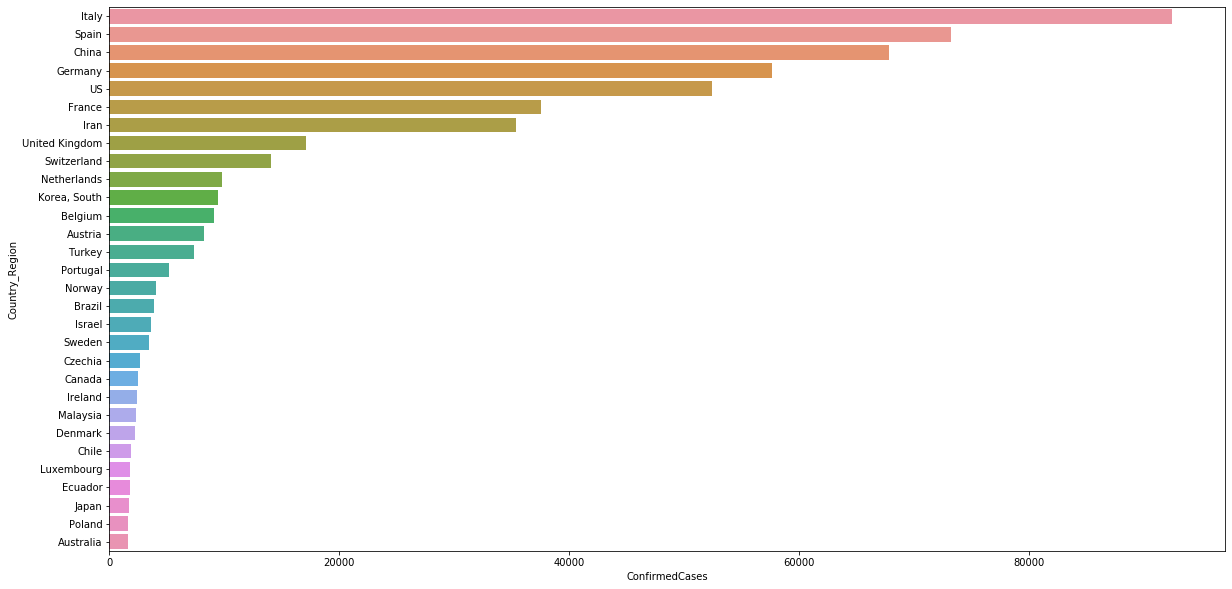

In [185]:
#Visualize the top 30 most confirmed cases in the world

grouped = train.groupby('Country_Region')['ConfirmedCases'].max().reset_index()
plt.figure(figsize=(20,10))
sns.barplot(x='ConfirmedCases', y='Country_Region', 
            data=grouped[grouped['ConfirmedCases'] != 0].sort_values(by='ConfirmedCases', ascending=False).head(30))

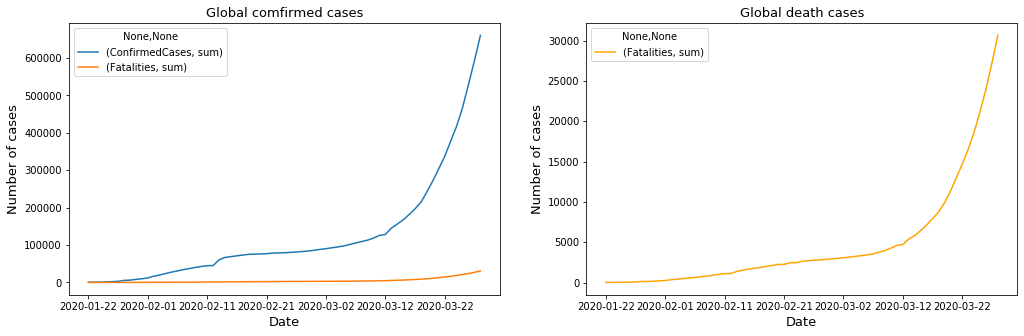

In [186]:
confirmedCases_by_Dates = train.groupby('Date').agg(
    {'ConfirmedCases':['sum']})
fatality_by_Dates = train.groupby('Date').agg(
    {'Fatalities':['sum']})
total_date = confirmedCases_by_Dates.join(fatality_by_Dates)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5)) #(row, col)

ax1.set_title("Global comfirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
total_date.plot(ax=ax1)

ax2.set_title("Global death cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)
fatality_by_Dates.plot(ax=ax2, color='orange')

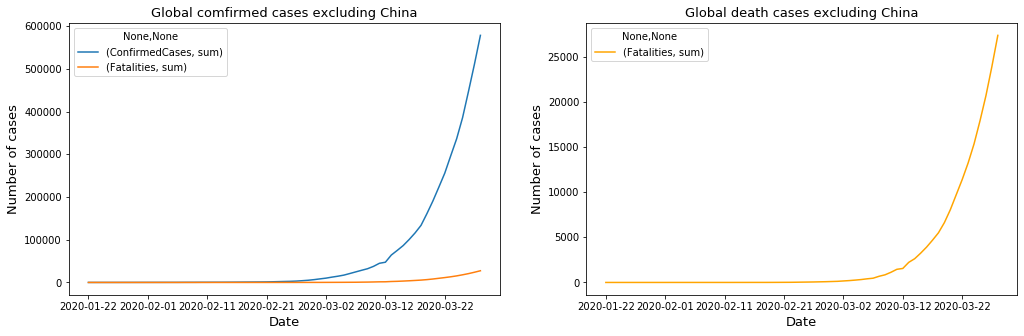

In [187]:
# Data excluding China 
confirmedCases_noChina = train[train['Country_Region'] != 'China'].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_noChina = train[train['Country_Region']!= 'China'].groupby('Date').agg({'Fatalities':['sum']})
total_date_noChina = confirmedCases_noChina.join(fatality_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5)) #(row, col)

ax1.set_title("Global comfirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
total_date_noChina.plot(ax=ax1)

ax2.set_title("Global death cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)
fatality_noChina.plot(ax=ax2, color='orange')

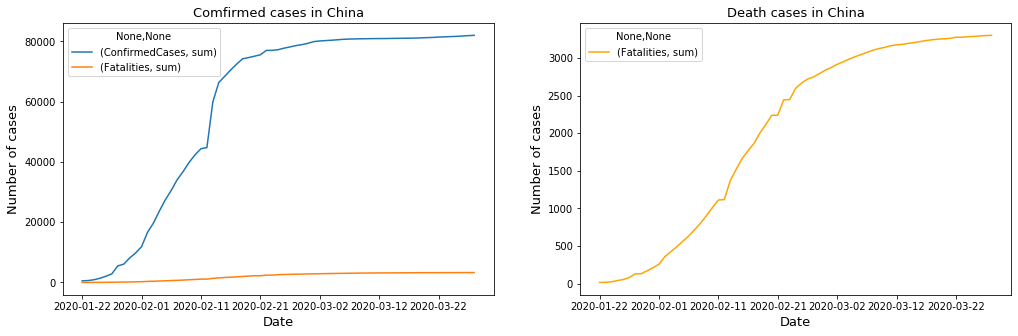

In [188]:
# Cases in China

confirmedCases_inChina = train[train['Country_Region'] == 'China'].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_inChina = train[train['Country_Region'] == 'China'].groupby('Date').agg({'Fatalities':['sum']})
total_date_inChina = confirmedCases_inChina.join(fatality_inChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5)) #(row, col)

ax1.set_title("Comfirmed cases in China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
total_date_inChina.plot(ax=ax1)

ax2.set_title("Death cases in China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)
fatality_inChina.plot(ax=ax2, color='orange')

## Examine cases outside China
Here we will choose `['Italy', 'Germany', 'Spain', 'Korea, South', 'Taiwan', 'Brunei']`.
1. `Italy`: They became the highest confirmed cases in the world (now shifted to US)
2. `Germany`: They have high confirmed cases as othe European counrtries, but still keeps the death rate low comparing to Spain or Britain.
3. `Spain`: The rate of the increase of confirmed cases and fatality in Spain is incredibly fast.
4. `Korea, South`: It is an Asian Country near China which is supposed to be hugely influenced by China.
5. `Taiwan`: Taiwan is a country that may be hugely affected by China as well considering its location.
6. `Brunei`: It is a small country where people have closer interactions. And it is pretty similar to the town I am living in.

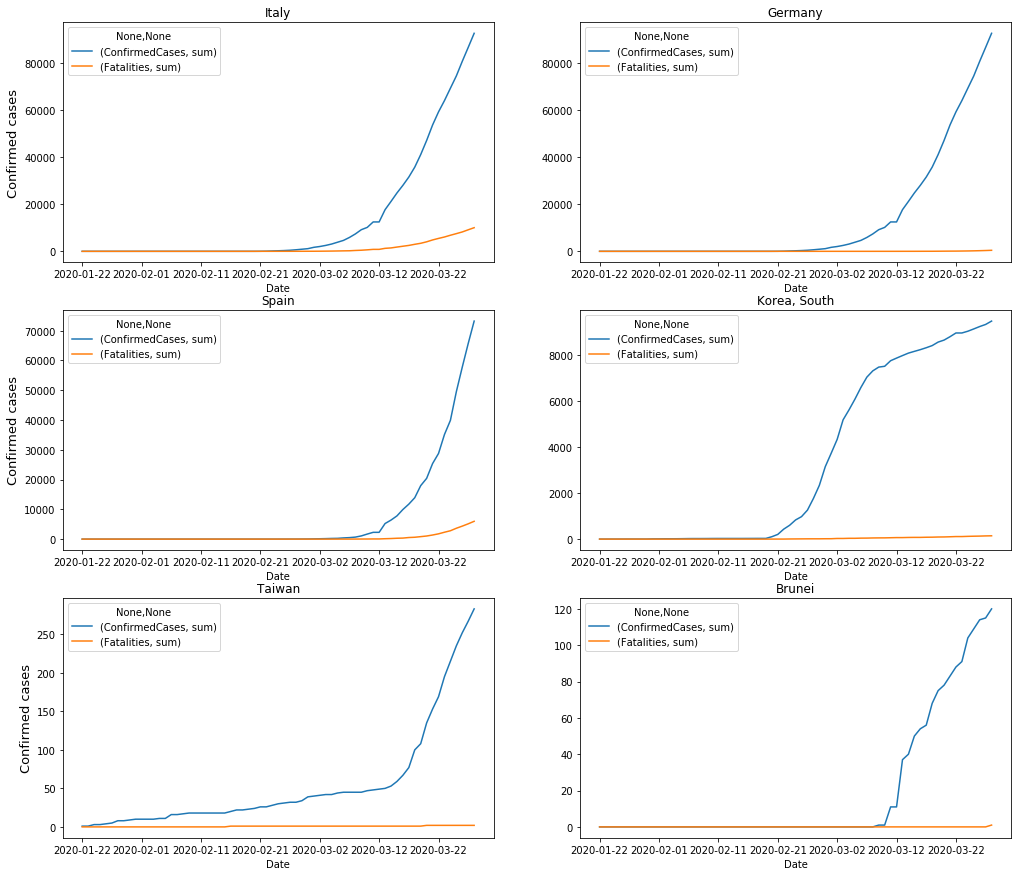

In [189]:
# Visualize the data

# Italy
confirmed_Italy = train[train['Country_Region'] == 'Italy'].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_Italy = train[train['Country_Region'] == 'Italy'].groupby('Date').agg({'Fatalities':['sum']})
total_Italy = confirmed_Italy.join(fatality_Italy)

# Germany
confirmed_Germany = train[train['Country_Region'] == 'Germany'].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_Germany = train[train['Country_Region'] == 'Germany'].groupby('Date').agg({'Fatalities':['sum']})
total_Germany = confirmed_Italy.join(fatality_Germany)

# Spain
confirmed_Spain = train[train['Country_Region'] == 'Spain'].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_Spain = train[train['Country_Region'] == 'Spain'].groupby('Date').agg({'Fatalities':['sum']})
total_Spain = confirmed_Spain.join(fatality_Spain)

# Korea, South
confirmed_SK = train[train['Country_Region'] == 'Korea, South'].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_SK = train[train['Country_Region'] == 'Korea, South'].groupby('Date').agg({'Fatalities':['sum']})
total_SK = confirmed_SK.join(fatality_SK)

#Taiwan
confirmed_Taiwan = train[train['Country_Region'] == 'Taiwan*'].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_Taiwan = train[train['Country_Region'] == 'Taiwan*'].groupby('Date').agg({'Fatalities':['sum']})
total_Taiwan = confirmed_Taiwan.join(fatality_Taiwan)

#Brunei
confirmed_Brunei = train[train['Country_Region'] == 'Brunei'].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_Brunei = train[train['Country_Region'] == 'Brunei'].groupby('Date').agg({'Fatalities':['sum']})
total_Brunei = confirmed_Brunei.join(fatality_Brunei)


plt.figure(figsize=(17,15))
plt.subplot(3, 2, 1)
total_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed cases", size=13)

plt.subplot(3, 2, 2)
total_Germany.plot(ax=plt.gca(), title='Germany')

plt.subplot(3, 2, 3)
total_Spain.plot(ax=plt.gca(), title='Spain')
plt.ylabel("Confirmed cases", size=13)

plt.subplot(3, 2, 4)
total_SK.plot(ax=plt.gca(), title='Korea, South')

plt.subplot(3, 2, 5)
total_Taiwan.plot(ax=plt.gca(), title='Taiwan')
plt.ylabel("Confirmed cases", size=13)

plt.subplot(3, 2, 6)
total_Brunei.plot(ax=plt.gca(), title='Brunei')


### What we can get from the graph
1. After 2020-03-02, the confirmed cases of these 6 countries started to boom exponentially.
2. Among the 6 countries, only the curve of South Korea is flattening. She probably got over the peak.
3. The fatality of Germany is abnormally low comparing to other European countries, i.e. Spain and Italy.
4. Asian countries have lower fatality and confirmed cases. Maybe it is about the habit of asian people wearing masks. 

### Now we see the percentage of population infected in these countries.
*Population data are from [Worldometer](https://www.worldometers.info/world-population/population-by-country/)*

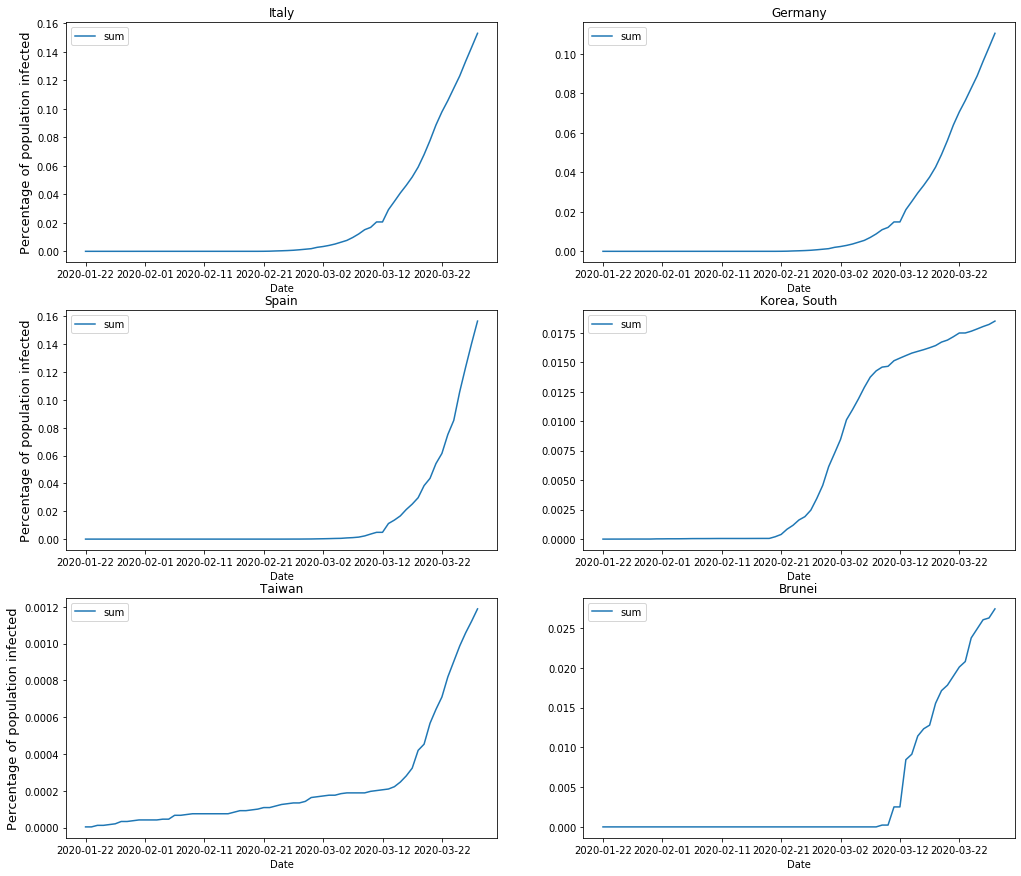

In [190]:
p_Italy = 60461826
p_Spain = 46754778
p_Germany = 83783942
p_SK = 51269185
p_Taiwan = 23816775
p_Brunei = 437479

# Italy
total_Italy.ConfirmedCases = total_Italy.ConfirmedCases/p_Italy*100
total_Italy.Fatalities = total_Italy.Fatalities/p_Italy*100

# Spain
total_Spain.ConfirmedCases = total_Spain.ConfirmedCases/p_Spain*100
total_Spain.Fatalities = total_Spain.Fatalities/p_Spain*100

# Germany
total_Germany.ConfirmedCases = total_Germany.ConfirmedCases/p_Germany*100
total_Germany.Fatalities = total_Germany.Fatalities/p_Germany*100

# SK
total_SK.ConfirmedCases = total_SK.ConfirmedCases/p_SK*100
total_SK.Fatalities = total_SK.Fatalities/p_SK*100

# Taiwan
total_Taiwan.ConfirmedCases = total_Taiwan.ConfirmedCases/p_Taiwan*100
total_Taiwan.Fatalities = total_Taiwan.Fatalities/p_Taiwan*100

# Brunei
total_Brunei.ConfirmedCases = total_Brunei.ConfirmedCases/p_Brunei*100
total_Brunei.Fatalities = total_Brunei.Fatalities/p_Brunei*100

plt.figure(figsize=(17,15))
plt.subplot(3, 2, 1)
total_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Percentage of population infected", size=13)

plt.subplot(3, 2, 2)
total_Germany.ConfirmedCases.plot(ax=plt.gca(), title='Germany')

plt.subplot(3, 2, 3)
total_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylabel("Percentage of population infected", size=13)

plt.subplot(3, 2, 4)
total_SK.ConfirmedCases.plot(ax=plt.gca(), title='Korea, South')

plt.subplot(3, 2, 5)
total_Taiwan.ConfirmedCases.plot(ax=plt.gca(), title='Taiwan')
plt.ylabel("Percentage of population infected", size=13)

plt.subplot(3, 2, 6)
total_Brunei.ConfirmedCases.plot(ax=plt.gca(), title='Brunei')

### Now we see how the virus was being infected since the first case in these 6 countries.

Remarks for Python programming: 

- Be careful of `and` and `&`. Former one will give error message in the case `cell 36`.
    
    `ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().`


- Also remember to add `()` to ensure there's no **ambiguity**. 


- `plt.legend()` shows labels to give better understanding. 

   `legend(loc=' ')` tells where to put the rectangle. `legend(loc='best')` can automatically put in the **best** postion.
    
    `legend(labels=[])` can rename the labels. Remember it should a list.

btw, `bold` in Markdown is `**text**`.

Text(0, 0.5, 'Infected cases')

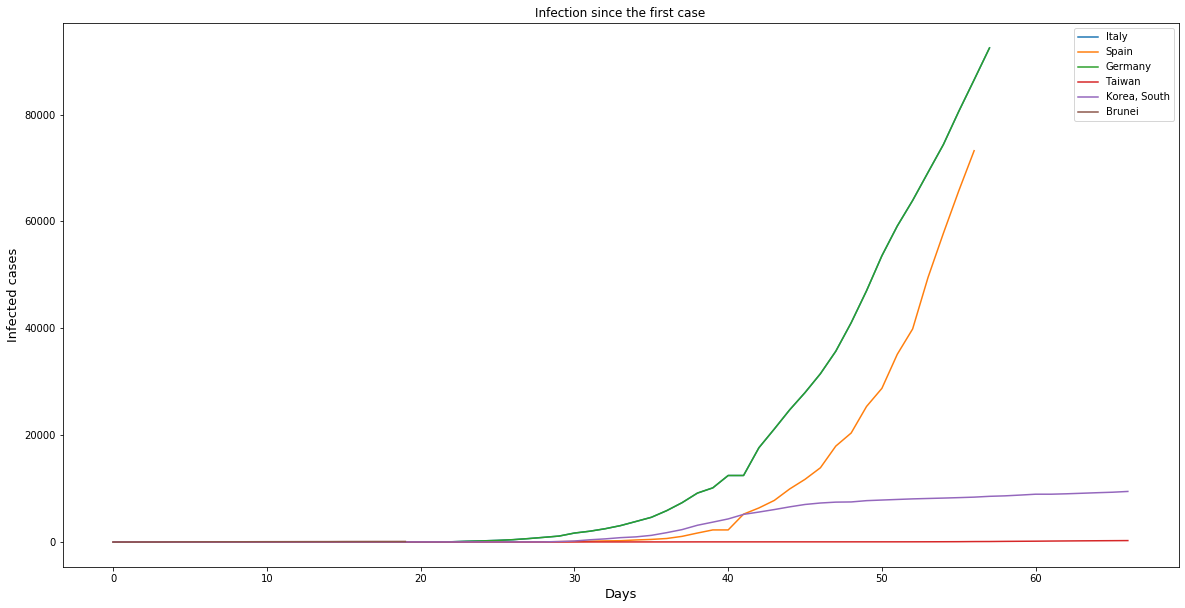

In [191]:

# Italy
confirmed_first_Italy = train[(train['Country_Region'] == 'Italy') & train['ConfirmedCases'] != 0].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_first_Italy = train[(train['Country_Region'] == 'Italy') & train['ConfirmedCases'] != 0].groupby('Date').agg({'Fatalities':['sum']})
total_first_Italy = confirmed_first_Italy.join(fatality_first_Italy)

# Germany
confirmed_first_Germany = train[(train['Country_Region'] == 'Germany') & train['ConfirmedCases'] != 0].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_first_Germany = train[(train['Country_Region'] == 'Germany') & train['ConfirmedCases'] != 0].groupby('Date').agg({'Fatalities':['sum']})
total_first_Germany = confirmed_first_Italy.join(fatality_first_Germany)

# Spain
confirmed_first_Spain = train[(train['Country_Region'] == 'Spain') & train['ConfirmedCases'] != 0].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_first_Spain = train[(train['Country_Region'] == 'Spain') & train['ConfirmedCases'] != 0].groupby('Date').agg({'Fatalities':['sum']})
total_first_Spain = confirmed_first_Spain.join(fatality_first_Spain)

# Korea, South
confirmed_first_SK = train[(train['Country_Region'] == 'Korea, South') & train['ConfirmedCases'] != 0].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_first_SK = train[(train['Country_Region'] == 'Korea, South') & train['ConfirmedCases'] != 0].groupby('Date').agg({'Fatalities':['sum']})
total_first_SK = confirmed_first_SK.join(fatality_first_SK)

#Taiwan
confirmed_first_Taiwan = train[(train['Country_Region'] == 'Taiwan*') & train['ConfirmedCases'] != 0].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_first_Taiwan = train[(train['Country_Region'] == 'Taiwan*') & train['ConfirmedCases'] != 0].groupby('Date').agg({'Fatalities':['sum']})
total_first_Taiwan = confirmed_first_Taiwan.join(fatality_first_Taiwan)

#Brunei
confirmed_first_Brunei = train[(train['Country_Region'] == 'Brunei') & train['ConfirmedCases'] != 0].groupby('Date').agg({'ConfirmedCases':['sum']})
fatality_first_Brunei = train[(train['Country_Region'] == 'Brunei') & train['ConfirmedCases'] != 0].groupby('Date').agg({'Fatalities':['sum']})
total_first_Brunei = confirmed_first_Brunei.join(fatality_first_Brunei)

it = [i for i in total_first_Italy.ConfirmedCases['sum'].values]
gn = [i for i in total_first_Germany.ConfirmedCases['sum'].values]
sp = [i for i in total_first_Spain.ConfirmedCases['sum'].values]
sk = [i for i in total_first_SK.ConfirmedCases['sum'].values]
tw = [i for i in total_first_Taiwan.ConfirmedCases['sum'].values]
bn = [i for i in total_first_Brunei.ConfirmedCases['sum'].values]

plt.figure(figsize=(20,10))
plt.plot(it)
plt.plot(sp)
plt.plot(gn)
plt.plot(tw)
plt.plot(sk)
plt.plot(bn)
plt.legend(labels=['Italy', 'Spain', 'Germany', 'Taiwan', 'Korea, South', 'Brunei'], loc='best')
plt.title("Infection since the first case")
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)



# Let's set up our SIR model
*Remark: Oh I just found that Markdown supports LaTex!!*

The key idea of estimating the model parameters is to choose the parameters $\beta$, $\gamma$ and $I(0)$ such that they **minimize the square of errors between the observed data and the model predictions**. [[Reference: HKU]](https://hkumath.hku.hk/~ntw/SCNC1001-2004b.pdf) [[Reference2: Wiki]](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) [[Reference3: lewuathe.com]](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html) 

## Brief Notes of SIR Models
### Reasons why I use SIR instead of other models
[x] MSIR, MSEIR and MSEIRS --> related to newborn babies, the duration of this epidemic is too short for this kind of variation, we do not count.

[x] SEIR --> Given data cannot give any insights for the exposed class. And it seems the patient will be infective after s/he got infected, i.e. do not need exposed class.

[x] SEIS --> The virus is fatal and healable, we need recovered class.

Personally I think we can have a model which is mixed by SIR and SEIS.

According to some studies, patient will get re-infected after s/he recovered. (However, maybe the number of cases are too small to be counted/considered.)

Maybe we can have a SIRS model(?), flow diagram as the following:

$[Susceptible] --> [Infective] --> [Recovered] --> [Susceptible]$

If we can get to know more about the virus, our prediction towards COVID-19 will be more accurate (which is obvious). For example, some studies show males are easier to get infected. We can also take genders and other factors (social activies/habits of individuals, hygiene measures, etc.) into account. However, it takes a lot of efforts and the given data is not informative enough to do so. I think local Health Department should conduct study about that and predict local outbreak...

Alright.

### Remarks
1. SIR model is *dynamic* --> numbers in each class can fluctuate in different time intervals.
2. During an *epidemic*, the number of susceptibles may fall rapidly since they are infected and go in the Infective or Recovered class.
3. Flow diagram of the SIR model:

$[Susceptible] --> [Infective] --> [Recovered]$

4. For the transitions between two classes, there will be different rates, i.e. $\beta$ and $\gamma$.
5. $R_{0}$ is the **basic reproduction number**.

### Assumptions
- Population is large and **constant**
    - i.e. No birth, death, immigration or emigration

- Homogeneous mixing
    - i.e. Each pair of individuals has equal probability of getting in touch with each other
    
### Equations
1. **Susceptible class**, $S_{t} = S(t)$ = number of susceptibles
    - Currently healthy, i.e. Not being infected.
2. **Infective class**, $I_{t} = I(t)$ = number of infectives
    - Those who are infected and contagious.
3. **Recovered class**, $R_{t} = R(t)$ = number of recovered
    - Those who cannot get the virus, either **died** or recovered permanently.
    
For $t+1$ interval, 

the number of susceptibles will be $S_{t+1} = S_{t} - \beta S_{t}I_{t}$

the number of infectives will be $I_{t+1} = I_t + \beta S_{t}I_{t} - \gamma I_{t}$

the number of recovered will be $R_{t+1} = R_{t} + \gamma I_{t}$

$S(0)$, $I(0)$ and $R(0)$ is set to be $0$.

Differentiation of the 3 equations: \begin{equation}\frac{dS}{dt}=-\beta S_{t}I_{t}\end{equation}

\begin{equation}\frac{dI}{dt}=\beta S_{t}I_{t}-\gamma I_{t}\end{equation}

\begin{equation}\frac{dR}{dt}=\gamma I_{t}\end{equation}

### When will an epidemic occurs?
- $\Delta I > 0$ for some time $t$, i.e. the number of infectives will increase for some time $t$. (When $S_{t} > \frac{\gamma}{\beta}$, i.e. infective rate is higher than recovered rate.)

- If $\Delta I < 0$ for all times, i.e. the number of infectives will **NOT** increase and there will not have an outbreak. (When $S_{t} < \frac{\gamma}{\beta}$, i.e. recovered rate is higher than the infective rate)

- If $\Delta I = 0$, it means the population is virus-free. (When $S_{t} = \frac{\gamma}{\beta}$)

- It is important to know when $\frac{dI}{dt}=(\beta S_{t}I_{t}-\gamma)I_{t}$ is **positive, zero or negative**.


We will have an *outbreak* **if and only if**
\begin{equation}R_{0}=\frac{\beta}{\gamma}S_{0}>1\end{equation}

If $R_{0} > 1$: Epidemic

If $R_{0} = 1$: No growths in the number of infectives

If $R_{0} < 1$: Sucessful control of infection

...

# Implementation of the SIR Model

In [192]:
# Susceptible class
def S(beta, s, i):
    return (-beta*s*i)

# Infective class
def I(beta, gamma, s, i):
    return (beta*s*i - gamma*i)

# Recovered class
def R(gamma, i):
    return (gamma*i)

I will try to use `Runge-Kutta Method` to solve the equations. [[Code reference]](https://rosettacode.org/wiki/Runge-Kutta_method#Alternate_solution)

Suppose we only have 1 infective at $t=0$:
$S_{0} = N-1$,
$I_{0} = 1$,
$R_{0} = 0$, where $N$ = world population. We are going to solve the equation over range $t = 0, 1, ..., 10000$ with step value $h = 0.1$.

For the choice of step value $h$: 
> The step size is adapted such that the estimated error stays below a user-defined threshold: If the error is too high, a step is repeated with a lower step size; if the error is much smaller, the step size is increased to save time.  

In [193]:
def rk4(s, i, r, S, I, R, beta, gamma, h):
    s1 = S(beta, s, i)*h
    i1 = I(beta, gamma, s, i)*h
    r1 = R(gamma, i)*h
    
    sk = s + s1*0.5
    ik = i + i1*0.5
    rk = r + r1*0.5
    
    s2 = S(beta, sk, ik)*h
    i2 = I(beta, gamma, sk, ik)*h
    r2 = R(gamma, ik)*h
    
    sk = s + s2*0.5
    ik = i + i2*0.5
    rk = r + r2*0.5
    
    s3 = S(beta, sk, ik)*h
    i3 = I(beta, gamma, sk, ik)*h
    r3 = R(gamma, ik)*h
    
    sk = s + s3*0.5
    ik = i + i3*0.5
    rk = r + r3*0.5
    
    s4 = S(beta, sk, ik)*h
    i4 = I(beta, gamma, sk, ik)*h
    r4 = R(gamma, ik)*h
    
    s = s + (s1 + 2*s2 + 2*s3 + s4)/6
    i = i + (i1 + 2*i2 + 2*i3 + i4)/6
    r = r + (r1 + 2*r2 + 2*r3 + r4)/6
    
    return s, i, r

In [194]:
def SIR(N, beta, gamma, h):
    s = float(N-1)/N
    i = float(1)/N
    r = 0
    
    sus, inf, rec = [], [], []
    for j in range(10000):
        s, i, r = rk4(s, i, r, S, I, R, beta, gamma, h)
        sus.append(s)
        inf.append(i)
        rec.append(r)
    return sus, inf, rec

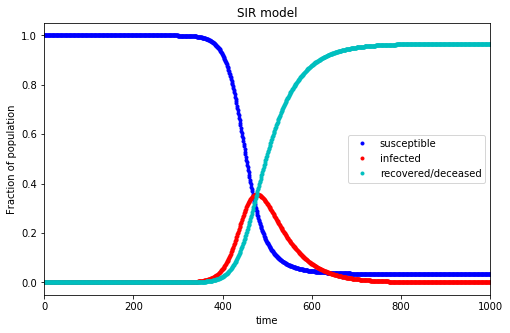

In [195]:
N = 7577130400
sus, inf, rec = SIR(N, 0.7, 0.2, 0.1)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()


# Let's plug in real data


### Remarks
The use of [`integrate.odeint()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

The use of `optimize.curve_fit()`: [reference1](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), [reference2](https://lmfit.github.io/lmfit-py/model.html)

be careful of variable names...... 

(Warning)

/Users/gloriachan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


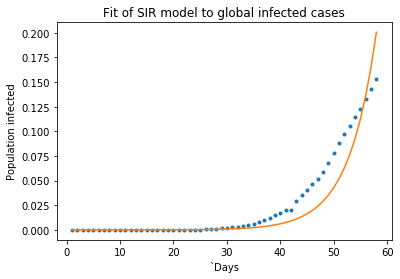

Optimal parameters: beta = 0.46611360669866836 and gamma =  0.27296851620422347


In [281]:
p_Italy = float(p_Italy)
df = total_Italy[9:]
df['days']=list(range(1, len(df)+1))

y = [i for i in df.ConfirmedCases['sum'].values]
y = np.array(y, dtype=float)
x = df.days
x = np.array(x, dtype=float)

inf_0 = y[0]
sus_0 = p_Italy - inf_0
rec_0 = float(0)

def sir_model(ydata, xdata, beta, gamma):
    sus = -beta * ydata[0] * ydata[1]/p_Italy
    rec = gamma*ydata[1]
    inf = -(sus+rec)
    return sus, inf, rec

def fit(xdata, beta, gamma):
    return integrate.odeint(sir_model, (sus_0, inf_0, rec_0), xdata, 
                            args=(beta, gamma))[:,1]

best_vals, covar = optimize.curve_fit(fit, x, y, bounds=([0, 0], [1, 1]))
fitted = fit(x, best_vals[0], best_vals[1])

plt.plot(x, y, '.')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("`Days")
plt.show()
print("Optimal parameters: beta =", best_vals[0], "and gamma = ", best_vals[1])
